<a href="https://colab.research.google.com/github/mlvlab/KCCV2022-tutorial/blob/main/KCCV2022_Object_Detection_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Object Detection with PyTorch**



---





---


**1. Dataset**


*   COCO2017 Val Data


---






In [ ]:
# Import required packages/modules first
import os 
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
from torchvision.datasets import CocoDetection

In [ ]:
# Downloads images and annotation files 

!wget http://images.cocodataset.org/zips/val2017.zip
!mkdir coco
!unzip val2017.zip -d ./coco/

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!mkdir anno
!unzip annotations_trainval2017.zip -d ./anno

--2022-02-23 06:11:41--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.40.36
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.40.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.1MB/s    in 2.5s    

2022-02-23 06:11:43 (96.1 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: ./anno/annotations/instances_train2017.json  
  inflating: ./anno/annotations/instances_val2017.json  
  inflating: ./anno/annotations/captions_train2017.json  
  inflating: ./anno/annotations/captions_val2017.json  
  inflating: ./anno/annotations/person_keypoints_train2017.json  
  inflating: ./anno/annotations/person_keypoints_val2017.json  


In [ ]:
image_path = os.getcwd() + '/coco/val2017/'
anno_path = os.getcwd() + '/anno/annotations/instances_val2017.json'

#transform = T.Compose([T.ToTensor()])
coco_datas = CocoDetection(root = image_path, annFile= anno_path)
coco_datas

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


Dataset CocoDetection
    Number of datapoints: 5000
    Root location: /content/coco/val2017/

In [ ]:
# COCO instance category names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
# Visualize original picture before detection

import matplotlib.pylab as plt
import cv2
import numpy as np

def gt_image_visualize(idx):
  img, targets = coco_datas[idx]
  # change PIL image to cv2 image
  cv_img = np.array(img)

  # Draw Rectangle with the coordinates
  # You must change the box format (x,y,w,h) to (x1,y1,x2,y2)
  # Put the text to the left top of each object
  for anno in targets:
    box = anno['bbox']
    label = COCO_INSTANCE_CATEGORY_NAMES[anno['category_id']]
    cv2.rectangle(cv_img, (int(box[0]), int(box[1])), (int(box[0] + (box[2])), int(box[1] + (box[3]))),  (0, 255, 0), 2) 
    cv2.putText(cv_img, label, (int(box[0]), int(box[1]) + 15),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2) # Write the prediction class

  # display the output image
  plt.figure(figsize=(10,10)) 
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cv_img)
  plt.show()

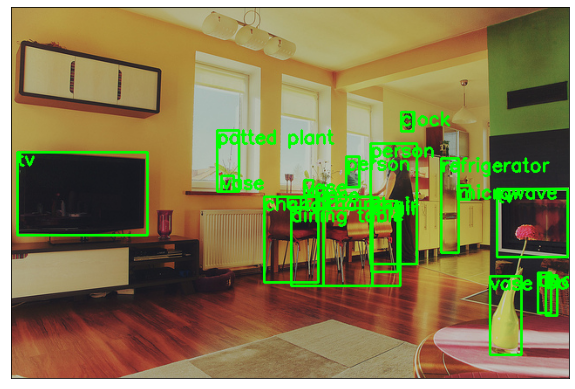

In [ ]:
gt_image_visualize(0)



---


**2. Object Detection with Faster R-CNN**

*  We will use a pretrained Faster R-CNN model: https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn

*  In inference, you have to change the model mode to evaluation.





---




In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(coco_datas, batch_size=1, shuffle=False, num_workers=4, collate_fn = collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



---

**Quiz1 : Write a inference function: get_prediction(img, model, transform, conf_threshold)**

* Detected boxes should exceed the confidence threshold

* Output format must be : [[x1,y1,x2,y2], [x3,y3,x4,y4], ... ], [l1,l2,...] numpy list

* Model Specitification: $\mathbb R^{B \times C \times H \times W} \rightarrow $ {'labels':..., 'boxes':..., 'scores':..., } (tensor)

* You should pay attention to the memory location (cuda or cpu?) of the current model.

---

In [ ]:
# Defining a function for get a prediction result from the model

def get_prediction(img, model, transform, conf_threshold):
  img = transform(img).unsqueeze(0)
  if torch.cuda.is_available():
    print('Use Cuda Device')
    model = model.cuda()
    img = img.cuda()
  model.eval()
  
  ##################################################################
  ##########################   To Do   #############################
  ##################################################################

  

  ##################################################################
  ##################################################################
  ##################################################################
  pred_boxes = pred_boxes.detach().cpu()
  pred_class = pred_class.detach().cpu()

  return pred_boxes, pred_class

In [ ]:
# Defining a api function for object detection

def object_detection_api(img, model, transform, threshold=0.5, rect_th=2, text_size=0.7, text_th=2):
  boxes, pred_cls = get_prediction(img, model, transform, threshold) # Get predictions

  img = np.array(img) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]),color=(0, 255, 255), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img, COCO_INSTANCE_CATEGORY_NAMES[pred_cls[i]], (int(boxes[i][0]), int(boxes[i][1]) + 15),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,255),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(10,10)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

---

**Quiz2 : Check how objects are detected by changing the threshold and model.**

* Which model has the fastest inference time? and why? 

---

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


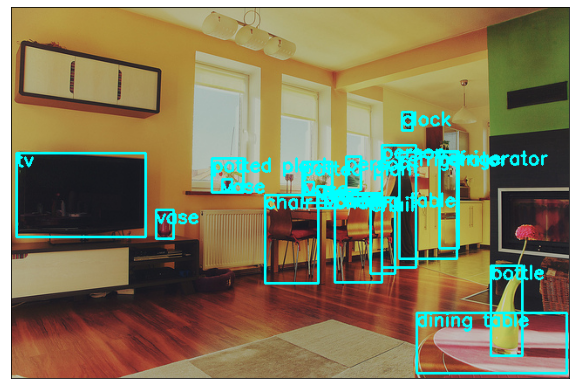

Inference time : 8.47


In [ ]:
import time 

img, target = coco_datas[0]

# T.Grayscale(), T.ColorJitter(brightness=.5, hue=.3), T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), T.RandomAutocontrast(), T.RandomAdjustSharpness(sharpness_factor=2)
transform = T.Compose([T.ToTensor()])

# Download the pretrained Faster R-CNN model from torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
# model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
# model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

start = time.time() 
object_detection_api(img, model, transform, threshold=0.7)
inf_time = time.time() - start
print("Inference time : %.2f"%inf_time)

---

**Quiz3 : Evaluation.**

* Write a simple evaluation code that finds indices between gt_bboxes and prediction which are matched if the box IoU is 0.5 or more with the same label.

* Note. If one gt object has already been used, the gt object is no longer used.

* If a gt box is not matched, its idx should be '-1'

* You must use the get_prediction code you wrote.

* Hint. Use torchvision.ops.box_iou: https://pytorch.org/vision/stable/_modules/torchvision/ops/boxes.html#box_iou


---

In [ ]:
def get_match_ids(img_idx, model, transform, conf_threshold=0.3, iou_threshold=0.5):

  # get image from idx 
  img, target = coco_datas[img_idx]
  gt_labels, gt_bboxes = get_annotations(target)
  
  ##################################################################
  ##########################   To Do   #############################
  ##################################################################
  
  
  
  ##################################################################
  ##################################################################
  ##################################################################
  return pred_bboxes, max_iou_ids.numpy(), int( (match_cnt * 100) / len(gt_bboxes))


In [ ]:
 # gt annotations preprocessing

def get_annotations(target):
  gt_bboxes, gt_labels = [], []
  for anno in target:
    gt_label = anno['category_id']
    gt_box = anno['bbox'].copy()
    gt_box[2] = gt_box[0] + gt_box[2]
    gt_box[3] = gt_box[1] + gt_box[3]
    
    gt_labels.append(gt_label)
    gt_bboxes.append(gt_box)
  gt_labels = torch.from_numpy(np.array(gt_labels))
  gt_bboxes = torch.from_numpy(np.array(gt_bboxes))

  return gt_labels, gt_bboxes

In [ ]:
def visualize_detection(img_idx, pred_bboxes, ids):
  img, target = coco_datas[img_idx]
  gt_labels, gt_bboxes = get_annotations(target)

  cv_img = np.array(img)
  plt.figure(figsize=(40,40))
  for i, idx in enumerate(ids):
    plt.subplot((len(ids) // 4) + 1, 4, i + 1)
    temp_img = cv_img.copy()
    if idx is not -1:
      pred_box = pred_bboxes[idx]
      gt_box = gt_bboxes[i]
      label = COCO_INSTANCE_CATEGORY_NAMES[gt_labels[i]]
      cv2.rectangle(temp_img, (int(pred_box[0]), int(pred_box[1])), (int(pred_box[2]), int(pred_box[3])),  (0, 255, 255), 3) 
      cv2.rectangle(temp_img, (int(gt_box[0]), int(gt_box[1])), (int(gt_box[2]), int(gt_box[3])),  (0, 255, 0), 3) 
      cv2.putText(temp_img, label, (int(gt_box[0]), int(gt_box[1]) + 15),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 3)
      plt.imshow(temp_img)
      plt.xticks([])
      plt.yticks([])
  plt.show()

In [ ]:
transform = T.Compose([T.ToTensor()])
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

pred_bboxes, ids, acc = get_match_ids(0, model, transform, conf_threshold=0.7, iou_threshold=0.3)
acc

65

In [ ]:
ids

array([ 3,  2, -1,  1,  0,  9, -1,  4, 17, -1, 12, -1, -1,  5, 15, 11, -1,
        6, 16,  1])

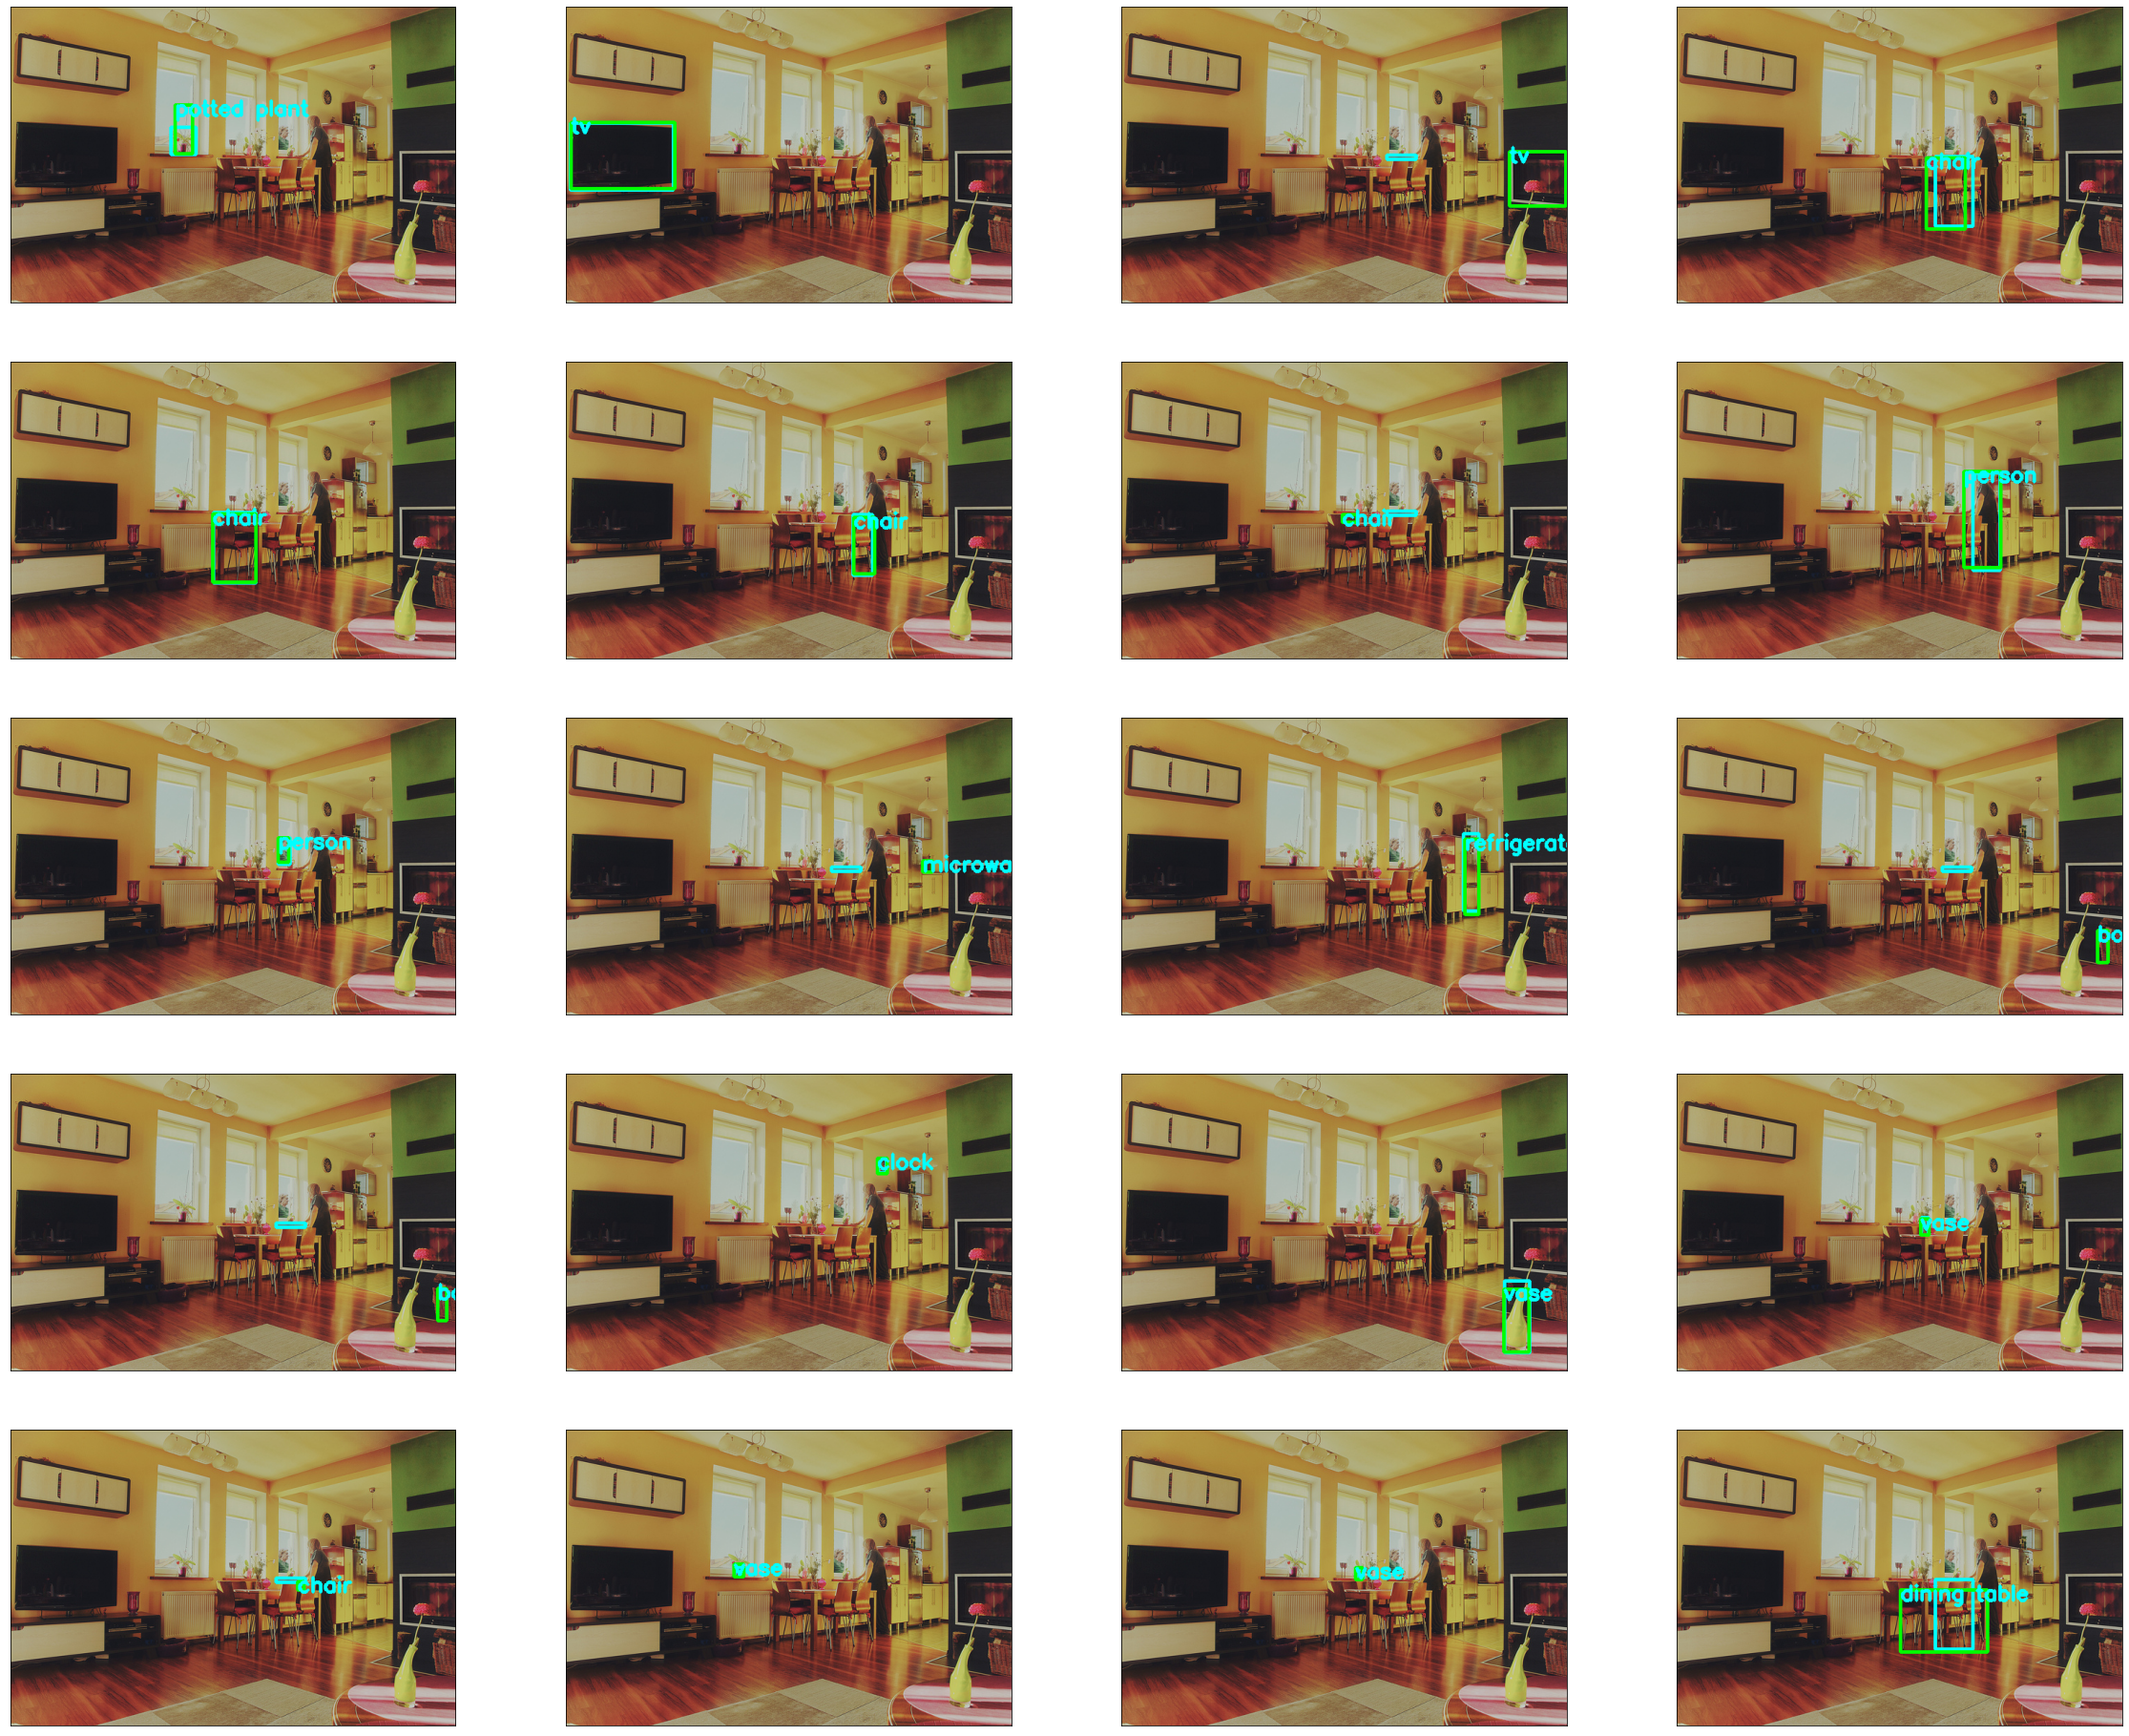

In [ ]:
visualize_detection(0, pred_bboxes, ids)

--- 

**Quiz4 : What is the shortcoming of the metric that we just implemented? Let's look at the results of coco_datas and think about.**

---